In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from helper.cluster import Kmeans
from helper.dimension_reduction import PCA, AutoEncoder

In [4]:
df_features = pd.read_csv("dataset.csv")
df_features = df_features.drop("Unnamed: 0", axis = 1)

In [5]:
np_features = df_features.select_dtypes([float, int]).to_numpy()

In [19]:
features_mean = np.mean(np_features)
features_std = np.std(np_features)
std_np_features = (np_features - features_mean) / features_std

auto_encoder = AutoEncoder(3, 5, std_np_features)

In [20]:
auto_encoder.train_model(epochs=10, learning_rate=0.001)

start... epoch: 0
end... epoch: 0 --- loss: 8613.091614112258 --- Total time: 156.07
start... epoch: 1
end... epoch: 1 --- loss: 6582.578348971903 --- Total time: 155.82
start... epoch: 2
end... epoch: 2 --- loss: 6581.95062520355 --- Total time: 158.80
start... epoch: 3
end... epoch: 3 --- loss: 6584.467452675104 --- Total time: 168.47
start... epoch: 4
end... epoch: 4 --- loss: 6579.431952673942 --- Total time: 185.72
start... epoch: 5
end... epoch: 5 --- loss: 6577.609524611384 --- Total time: 182.54
start... epoch: 6
end... epoch: 6 --- loss: 6584.22985733673 --- Total time: 199.48
start... epoch: 7
end... epoch: 7 --- loss: 6580.962459489703 --- Total time: 173.46
start... epoch: 8
end... epoch: 8 --- loss: 6578.679212328047 --- Total time: 176.10
start... epoch: 9
end... epoch: 9 --- loss: 6579.352949813008 --- Total time: 181.96


In [24]:
encoded_data = []
for inputs in std_np_features:
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    
    if inputs_tensor.dim() == 1:
        inputs_tensor = inputs_tensor.unsqueeze(0)
    encoded_data.append(auto_encoder.get_encoder(data = inputs_tensor).numpy())

In [25]:
numpy_data = [tensor.squeeze() for tensor in encoded_data]

encoded_df = pd.DataFrame(numpy_data) 


In [23]:
encoded_df 

,0,1,2
0,0.0,0.0,2.575943
1,0.0,0.0,1.587165
2,0.0,0.0,2.333910
3,0.0,0.0,2.225424
4,0.0,0.0,2.187880
...,...,...,...
113995,0.0,0.0,4.458487
113996,0.0,0.0,4.458499
113997,0.0,0.0,3.073576
113998,0.0,0.0,3.225183


In [6]:
pca = PCA(3, np_features)
pcas = pca.get_pca()
first_pca = np.where(pca.explained_variance()[1] >= 0.75)[0][0]
pca = PCA(first_pca, np_features)
df_reduced = pd.DataFrame(pca.get_pca(), columns=[f'PC{i+1}' for i in range(first_pca)])

In [7]:
df_reduced["ID"] = df_features["track_id"]

In [8]:
X = df_reduced.select_dtypes([float, int]).values

In [9]:
kmeans = Kmeans(n_clusters=10, max_iter=1000)
kmeans.fit(X)

In [10]:
labels = kmeans.predict(X)

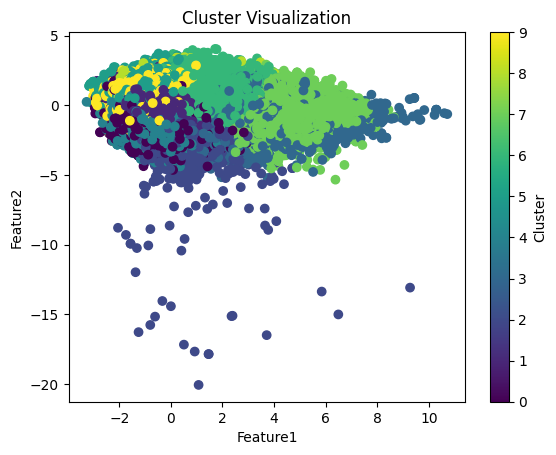

In [11]:
df_reduced['Cluster'] = labels

# Visualizing the clusters
plt.scatter(df_reduced['PC1'], df_reduced['PC2'], c=df_reduced['Cluster'], cmap='viridis')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Cluster Visualization')
plt.colorbar(label='Cluster')
plt.show()

In [18]:
cluster_sse = []
for i in range(1, 9):
    kmeans = Kmeans(n_clusters=i, max_iter=1000)
    kmeans.fit(X)
    cluster_sse.append(kmeans.error)

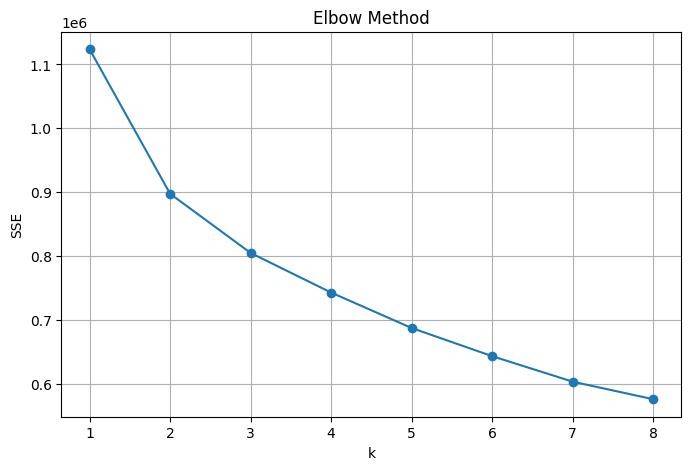

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), cluster_sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [40]:
previous_sse = None
sse_diff = []
for sse in cluster_sse:
    if previous_sse is None:
        previous_sse = sse
        continue

    sse_diff.append(previous_sse - sse)

    previous_sse = sse
    
max_diff_cluster = sse_diff.index(max(sse_diff)) + 2

In [41]:
max_diff_cluster

2

In [42]:
kmeans = Kmeans(n_clusters=max_diff_cluster, max_iter=1000)
kmeans.fit(X)
labels = kmeans.predict(X)

array([0, 1, 1, ..., 1, 0, 1])